# 3.9.2: Baseball 

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap08.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap08 import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py
Downloaded ModSimPy_Functions/chap08.py


In the previous notebook we developed a model of the flight of a
baseball, including gravity and a simple version of drag, but neglecting spin (i.e. the Magnus force) and the dependence of the coefficient of drag on velocity.

<br>

In this notebook we apply that model to an optimization problem. In general, *optimization* is a process for improving a design by searching for the parameters that maximize a benefit or minimize a cost. For example, in this chapter we'll find the angle you should hit a baseball to maximize the distance it travels. And we'll use a new function, called `maximize_scalar` that searches for this angle efficiently.

## The Manny Ramirez Problem

Manny Ramirez is a former member of the Boston Red Sox (an American
baseball team) who was notorious for his relaxed attitude and taste for practical jokes. Our objective in this chapter is to solve the following Manny-inspired problem:  What is the minimum effort required to hit a home run in Fenway Park?

<br>

Fenway Park is a baseball stadium in Boston, Massachusetts. One of its
most famous features is the "Green Monster", which is a wall in left
field that is unusually close to home plate, only 310 feet away. To
compensate for the short distance, the wall is unusually high, at 37
feet.

### Creating a system

Let's add these two parameters to our `params` object (`wall_distance` and `wall_height`, in meters):

In [ ]:
# Convert feet to meters
feet_to_meter = 0.3048
params = dict(
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    speed = 40,  # m / s

    mass = 145e-3,    # kg 
    diameter = 73e-3, # m 
    C_d = 0.33,       # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10,    # s
    
    wall_distance= 310*feet_to_meter,     # m
    wall_height= 37 * feet_to_meter)      # m

We'll need to adjust the `make_system` function to include our new parameters:

In [ ]:
def make_system(params):
    
    x, y, angle, speed, mass, diameter, C_d, rho, g, t_end, wall_distance, wall_height = params.values()
    
    # compute x and y components of velocity
    vx, vy = angle_to_components(speed,angle)
    
    # make the initial state
    init = pd.Series(dict(x=x, y=y, vx=vx, vy=vy))
    
    # compute the frontal area
    area = np.pi * (diameter/2)**2

    return dict(C_d=C_d, rho=rho, g=g, t_end=t_end,
                  mass=mass,wall_distance=wall_distance,
                  wall_height=wall_height,init = init,
                  area = area)

The answer we want is the minimum speed at which a ball can leave home plate and still go over the Green Monster. We'll proceed in the
following steps:

<br>

1.  For a given speed, we'll find the optimal *launch angle*, that is, the angle the ball should leave home plate to maximize its height when it reaches the wall.

2.  Then we'll find the minimum speed that clears the wall, given that it has the optimal launch angle.

<br>

✅ Active reading: A projectile without drag will achieve its maximum distance when launched at a 45 degree angle.  When we include drag, do you think the optimal angle will be at, above or below 45 degrees?  Why?  

✅ ✅ Answer here.


### Finding the Range

Suppose we want to find the launch angle that maximizes the *range*, that is, the distance the ball travels in the air before landing. We'll use a function in a SciPy function called `minimize_scalar`, which takes a function and finds its minimum.

<br>

The function we pass to `minimize_scalar` should take launch angle in degrees, simulate the flight of a ball launched at that angle, and return the distance the ball travels along the $x$ axis.

In [ ]:
def range_func(angle, params):
    params_var = params.copy()
    params_var.update(dict(angle=angle))
    system = make_system(params_var)
    results, details = run_solve_ivp(system, slope_func,
                                     events=event_func)
    x_dist = results.iloc[-1].x
    return -x_dist

`range_func` makes a new `system` object with the given value of
`angle`. Then it calls `run_solve_ivp` and
returns the final value of `x` from the results.  In short, it tells us how far a ball will travel at the angle and speed given by the parameters.  Notice that since we want to *maximize* our function, we're multiplying `x_dist` by -1: this means that the "minimum" value of the function will actually be the largest $x$ value.

<br>

We can call `range_func` directly like this:

In [ ]:
range_func(46, params)

-98.88228655884004

With launch angle 45°, the ball lands about 99 meters from home plate.  Test the prediction you made above: about what angle produces the longest distance?

<br>

Now we can sweep a sequence of angles like this:

In [ ]:
angles = np.linspace(20, 80, 21)
sweep = pd.Series([],dtype=np.float64)

for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist

Here's what the results look like.

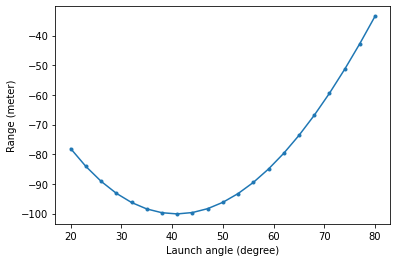

In [ ]:
sweep.plot(xlabel='Launch angle (degree)',
         ylabel='Range (meter)',marker='.');

The dots represent actual data points determined by `range_func`.  It looks like the range is maximized when the initial angle is near 40°.

### Finding the optimal angle

To find the optimal angle more precisely and more efficiently, we can use a SciPy algorithm called `minimize_scalar`.  Notice that range function has two arguments: `angle` and `params`.  When `minimize_scalar` is called, it will attempt to minimize the value of the `range_func` by sweeping through possible values for the first argument in the `range_func`, which in our case is `angle`.  

In [ ]:
res = spo.minimize_scalar(range_func, args=params)

The first parameter is `range_func`, the function we want to minimize.  `args` is a *keyword argument* that allows us to pass `params` on to `range_func`.

<br>

The return value from `minimize_scalar` is an object that contains the
results, including `x`, which is the angle that yielded the maximum
range, and `fun`, which is the function value at that angle (i.e. the distance the ball travels when the ball is launched at the optimal angle).

In [ ]:
res

     fun: -100.12417043314977
    nfev: 21
     nit: 12
 success: True
       x: 40.879288041405054

In [ ]:
print("When hit at an angle of", round(res.x,2), ", the ball travels", -round(res.fun,2), "meters")

When hit at an angle of 40.88 , the ball travels 100.12 meters


For these parameters, the optimal angle is about 41°, which yields a range of 100 m.
Now we have what we need to finish the problem; the last step is to find the minimum velocity needed to get the ball over the wall. 

---

## Summary

This notebook introduces an new tool, `minimize_scalar`, that provides an efficient way to search for the maximum of a function. We used it to find the launch angle that maximizes the distance a baseball flies through the air, given its initial velocity.

<br>

---


### Exercise 1

Let's finish off the Manny Ramirez problem:  What is the minimum effort required to hit a home run in Fenway Park?

<br>

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial speed that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

<br>

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range; we want the maximum height at the point where it reaches the wall.

<br>

As a first step, write an `event_func` that stops the simulation when the ball reaches the wall at `wall_distance`, which is a parameter in `params`.
Test your function with the initial conditions.

In [ ]:
# Define the event_func

def event_func(t,state,system):
    x,y,vx,vy = state
    return x - system['wall_distance']

In [ ]:
# Test event function
system = make_system(params)
event_func(0,system['init'],system)

-94.488

Next, write a function called `height_func` that takes a launch angle, simulates the flight of a baseball, and returns the height of the baseball when it reaches the wall.
Test your function with the initial conditions.

In [ ]:
# Define height function
def height_func(angle,params):
    params_var = params.copy()
    params_var.update(angle=angle)
    system = make_system(params_var)
    results, details = run_solve_ivp(system, slope_func,
                                     events=event_func)
    height_at_wall = results.iloc[-1].y
    return -height_at_wall

In [ ]:
# Test height_function
height_func(45,params)

-6.968278259866732

We know the ball that leaves the bat at 45 degrees travels about 99 meters, so it makes sense that it would be about 7 m above the ground when it passed the 94.5 m mark (that is, the location of the wall).

<br>

We now have a function that will tell us the height of the ball when it reaches the wall.  If we use this function in `maximize_scalar`, we can find the angle that will maximize this height.  Is it higher or lower than the angle that maximizes range?

In [ ]:
# Find the optimal angle
params['speed'] = 40
max_ang = spo.minimize_scalar(height_func,args=params)
print(max_ang.x, max_ang.fun)

43.10508101222 -7.217049532932872


The angle that maximizes the height at the wall is a little higher than the angle that maximizes range.  

<br>

We have maximized the height for a ball that has an initial velocity of 40 m/s.  Now, let's find the lowest speed that makes the height at the wall exactly 37 feet.  Essentially, we need to sweep through two parameters, angle and speed, to find the combination that will get us the lowest speed.

<br>

We have the tool to optimize the angle for a given speed.  Now we will use `root scalar` and an error function to find the lowest speed whose maximum height clears the wall.

<br>

Write an error function that takes a speed and a `system` object as parameters.  It should use `maximize_scalar` to find the angle that will produce the highest possible height of the ball at the wall, for the given speed.  Then it should return the difference between that optimal height and `wall_height`, which is a parameter in `params`.

<br>

This is the error function that we will try to set to zero with `root scalar`.

In [ ]:
# Define the error function

def error_func(speed,params):
    params_var = params.copy()
    params_var.update(speed=speed)
    
    # For a given speed, find the angle that gives the maximum height at the wall
    max_ang = spo.minimize_scalar(height_func, args=params_var)
    print("Speed",speed,"Angle", max_ang.x, "Height", -max_ang.fun)
    
    # Return the difference between the top of the wall and the optimal height
    # of the ball at the wall: this is what root_scalar will try to make zero
    # Remember that max_ang.fun is defined as a negative, so we can use addition
    # here
    return max_ang.fun + system['wall_height']

In [ ]:
# Test function
error_func(40,params)

Speed 40 Angle 43.10508101222 Height 7.217049532932872


4.060550467067129

Then use `root_scalar` to find the answer to the problem, the minimum speed that gets the ball out of the park.

In [ ]:
# Call root_scalar to find the angle and minimum speed to clear wall
res = root_scalar(error_func,params,bracket=[10,50])
res


Speed 10 Angle 90.99295139318595 Height -247.90591435495747
Speed 10.0 Angle 90.99295139318595 Height -247.90591435495747
Speed 50.0 Angle 52.22315262370028 Height 41.50778954033001
Speed 45.82187171741286 Angle 48.87006504341621 Height 28.30802774208858
Speed 40.763590036247486 Angle 43.94021954756723 Height 10.215857203423635
Speed 41.06043635032318 Angle 44.258219622995966 Height 11.3596754885331
Speed 41.039135933496325 Angle 44.2355244765709 Height 11.277995149271622
Speed 41.03708397669865 Angle 44.23333652294396 Height 11.270123349949685


      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 41.039135933496325

And just to check, run `error_func` with the value you found.

In [ ]:
# Check with error_function
error_func(41.03,params)

Speed 41.03 Angle 44.22578394431821 Height 11.242943191970653


0.03465680802934834